In [1]:
import xcast as xc 
import xarray as xr 
import cartopy.crs as ccrs 

week = 4

model = xr.open_dataset('data/MODEL_WEEK{}.nc'.format(week)).tp
obs = getattr(xr.open_dataset('data/OBS_COARSE_WEEK{}.nc'.format(week)), '__xarray_dataarray_variable__')

In [2]:
model = xc.regrid(model, obs.longitude, obs.latitude)

In [3]:
model = model.sel(longitude=slice(-120, -70), latitude=slice(20,60))
obs = obs.sel(longitude=slice(-120, -70), latitude=slice(20,60))

drymask = xc.drymask(obs, dry_threshold=0.1, quantile_threshold=0.3)
obs = obs*drymask 


hindcasts_det, hindcasts_prob = [], []
i=1
for xtrain, ytrain, xtest, ytest in xc.LeaveOneYearOut(model, obs):
    print("window {}".format(i))
    i += 1
    rmmx = xc.RollingMinMax(lead_low=-7, lead_high=7)
    rmmx.fit(xtrain)
    xtrain = rmmx.transform(xtrain)
    xtest = rmmx.transform(xtest)
    
    rmmy = xc.RollingMinMax(lead_low=-7, lead_high=7)
    rmmy.fit(ytrain)
    ytrain = rmmy.transform(ytrain)
    ytest = rmmy.transform(ytest)

    reg = xc.ACPAC()
    reg.fit(xtrain, ytrain)
    probs =  reg.predict_proba(xtest)
    preds = reg.predict(xtest)
    hindcasts_det.append(preds)
    hindcasts_prob.append(probs)
hindcasts_det = xr.concat(hindcasts_det, 'time')
hindcasts_prob = xr.concat(hindcasts_prob, 'time')


window 1


/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/reductions.py:616: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21


In [4]:
ohc = xc.RollingOneHotEncoder(lead_low=-7, lead_high=7) 
ohc.fit(obs)
T = ohc.transform(obs)
clim = xr.ones_like(T) * 0.333

In [5]:
mm = xc.RollingMinMax(lead_low=-7, lead_high=7) 
mm.fit(obs)
y_mm = mm.transform(obs)

In [6]:
clim_rps = xc.RankProbabilityScore(clim, T)
pred_rps = xc.RankProbabilityScore(hindcasts_prob, T)
rpss = 1 - pred_rps / clim_rps 

/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


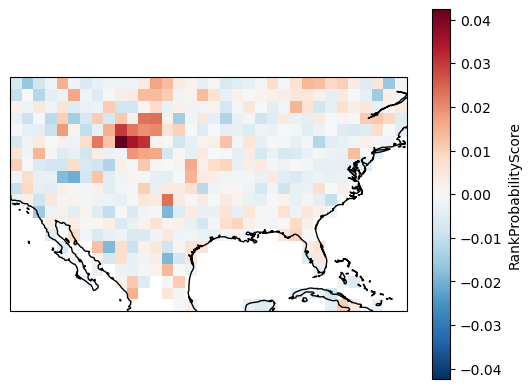

In [7]:
pl = rpss.plot(subplot_kws={'projection': ccrs.PlateCarree()})
c = pl.axes.coastlines()

In [8]:
pearson = xc.Pearson(hindcasts_det, y_mm)

/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packa

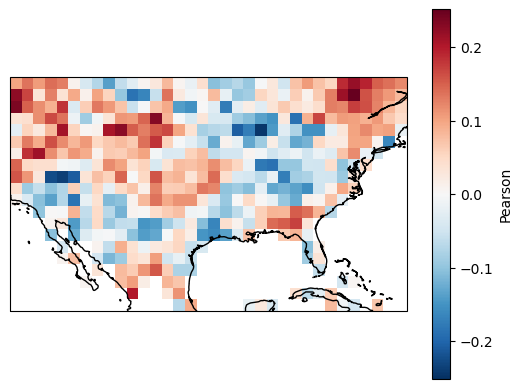

In [9]:
pl = pearson.plot(subplot_kws={'projection': ccrs.PlateCarree()})
c = pl.axes.coastlines()

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']


/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/kylehall/opt/anaconda3/envs/xcast_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


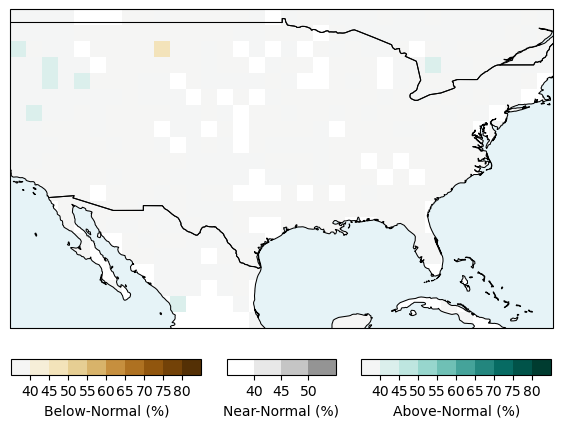

In [10]:
xc.view_probabilistic(hindcasts_prob.isel(time=0))